In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2026-02-23 15:24:29.884086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771860270.068418      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771860270.123843      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771860270.583347      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771860270.583406      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771860270.583412      55 computation_placer.cc:177] computation placer alr

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df = pd.read_csv("/kaggle/input/ag-news-classification-dataset/train.csv")
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
df.columns

Index(['Class Index', 'Title', 'Description'], dtype='object')

In [7]:
df['text'] = df['Title'] + " " + df['Description']

In [8]:
df['Class Index'] = df['Class Index'] - 1

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word)
             for word in words
             if word not in stop_words and len(word) > 2]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)

In [10]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,1),
    min_df=2,
    max_df=0.9
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['Class Index']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [13]:
svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.913125


In [14]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9147916666666667


In [20]:
lgb = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    n_estimators=150,
    learning_rate=0.1,
    n_jobs=-1
)

lgb.fit(X_train, y_train)

y_pred_lgb = lgb.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.142828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 472324
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 9257
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9025


In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    tree_method='hist',        
    max_depth=6,
    n_estimators=150,
    learning_rate=0.1,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8646666666666667


In [22]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

num_classes = len(np.unique(y))

model = Sequential([
    Dense(256, activation='relu', input_dim=X_train_dense.shape[1]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(
    X_train_dense,
    y_train,
    epochs=3,            # reduced for speed
    batch_size=256,
    validation_split=0.1
)

loss, acc = model.evaluate(X_test_dense, y_test)
print("Neural Network Accuracy:", acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1771861306.489258      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771861306.494316      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/3


I0000 00:00:1771861318.535265     190 service.cc:152] XLA service 0x7eb7cc0081a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771861318.535311     190 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771861318.535317     190 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771861318.812389     190 cuda_dnn.cc:529] Loaded cuDNN version 91002


 25/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4447 - loss: 1.3567

I0000 00:00:1771861320.543471     190 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8059 - loss: 0.6456 - val_accuracy: 0.9119 - val_loss: 0.2632
Epoch 2/3
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9314 - loss: 0.2015 - val_accuracy: 0.9055 - val_loss: 0.2733
Epoch 3/3
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9471 - loss: 0.1539 - val_accuracy: 0.9053 - val_loss: 0.2912
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9113 - loss: 0.2763
Neural Network Accuracy: 0.9112916588783264


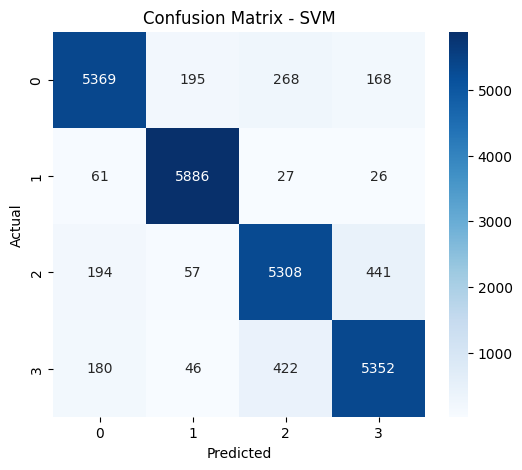

In [23]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

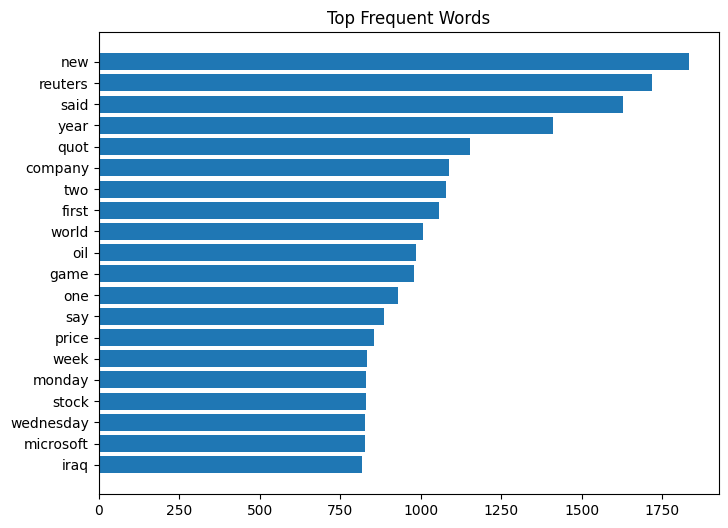

In [24]:
feature_names = vectorizer.get_feature_names_out()
tfidf_sum = np.array(X.sum(axis=0)).flatten()

top_indices = tfidf_sum.argsort()[-20:]
top_words = [feature_names[i] for i in top_indices]
top_values = tfidf_sum[top_indices]

plt.figure(figsize=(8,6))
plt.barh(top_words, top_values)
plt.title("Top Frequent Words")
plt.show()